In [1]:
from numpy.random import seed
seed(101)

import pandas as pd
import numpy as np


import tensorflow as tf
import keras
import keras.backend as K
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator,img_to_array,array_to_img
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Input, Dense, Dropout, Flatten, Activation, BatchNormalization
from keras.models import Model, load_model, save_model
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.callbacks import Callback, CSVLogger, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.optimizers import Adam

import os

from sklearn.metrics import auc, classification_report, confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
batch_size = 64
image_size = (96,96)

target_size = image_size
#target_size = (36,36)

In [3]:
root_dir = '.'
train_dir = os.path.join(root_dir,'input','train')
test_dir = os.path.join(root_dir,'input','test')

In [4]:
train_input = list(filter(lambda s: s.endswith(".tif"), os.listdir(train_dir)))
test_input = list(filter(lambda s: s.endswith(".tif"), os.listdir(test_dir)))
print("Train input files: {}".format(len(train_input)))
print("Test input files: {}".format(len(test_input)))

Train input files: 220025
Test input files: 57458


In [5]:
df = pd.read_csv("train_labels.csv", dtype=str)
df['path'] = df['id'].apply(lambda s: s+'.tif')
df.head()

,id,label,path
0,f38a6374c348f90b587e046aac6079959adf3835,0,f38a6374c348f90b587e046aac6079959adf3835.tif
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif
2,755db6279dae599ebb4d39a9123cce439965282d,0,755db6279dae599ebb4d39a9123cce439965282d.tif
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif
4,068aba587a4950175d04c680d38943fd488d6a9d,0,068aba587a4950175d04c680d38943fd488d6a9d.tif


In [6]:
ratio = df['label'].value_counts()[0]/df['label'].value_counts()[1]

print(df['label'].value_counts(), ratio)

0    130908
1     89117
Name: label, dtype: int64 1.468945319074924


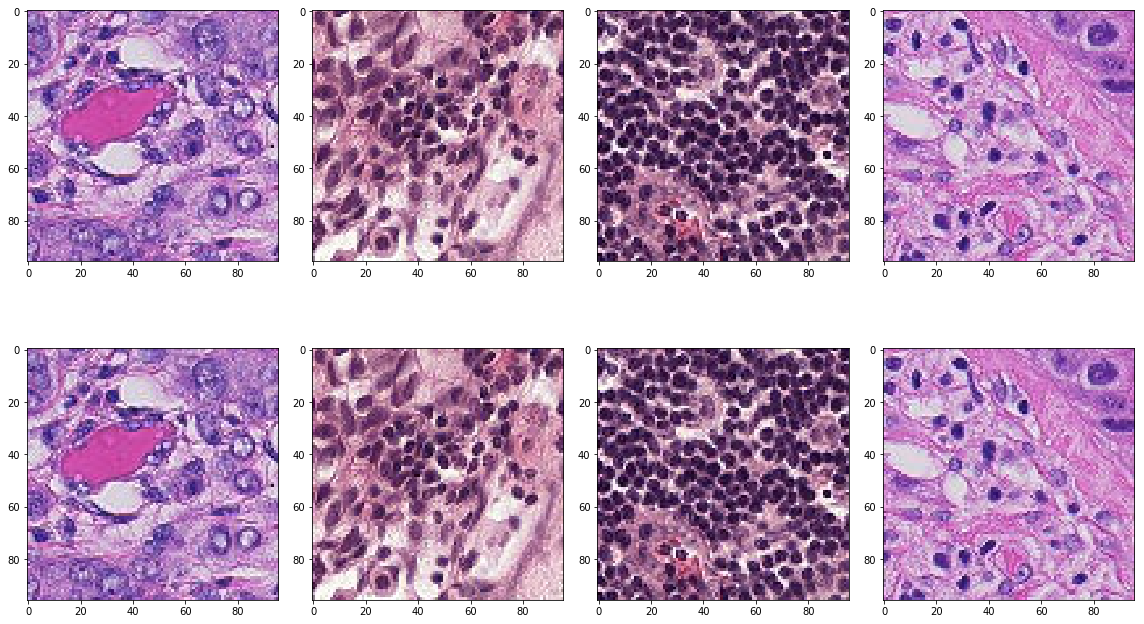

In [7]:
def target_crop(img,target_size):
    """
    Crop to central area
    
    From: 
    https://www.kaggle.com/c/histopathologic-cancer-detection/data
    
    A positive label indicates that the center 32x32px region
    of a patch contains at least one pixel of tumor tissue. 
    Tumor tissue in the outer region of the patch does not 
    influence the label. This outer region is provided to enable 
    fully-convolutional models that do not use zero-padding,
    to ensure consistent behavior when applied to a whole-slide image.
    """
    
    H = img.shape[0]//2
    W = img.shape[1]//2
    
    dh = target_size[0]//2
    dw = target_size[1]//2
    
    # Crop center region of *target_size
    img = img[H-dh:H+dh+1,W-dw:W+dw+1,:]
    
    return img

#Some visual check...

img_dir = train_dir
nrows = 2
ncols = 4
f, ax = plt.subplots(nrows=nrows,ncols=ncols, figsize=(4*ncols,5*nrows))
for j in range(0,ncols):
    img_path = os.path.join(img_dir,
                            df.loc[np.random.randint(df.shape[0]),'path'])
    img = plt.imread(img_path)
    ax[0,j].imshow(img)
    ax[1,j].imshow(target_crop(img, target_size))

plt.tight_layout()
plt.show()

In [8]:
#Small dataframe for learning sanity checks

tmp_df = df.sample(frac=0.1,replace=False,random_state=777)
tmp_df.shape

(22002, 3)

In [9]:
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df.label)
#train_df, val_df = train_test_split(tmp_df, test_size=0.2, stratify=tmp_df.label)

print(train_df.shape, val_df.shape)

(176020, 3) (44005, 3)


In [10]:
aug = {'horizontal_flip': True,
       'vertical_flip': True,
       'rotation_range': 90}

def preprocessing(x):
    #x = target_crop(x, target_size)
    
    x = (x - x.mean()) / x.std() if x.std() > 0 else x
    
    #preprocess_input(x)

    return x

datagen = ImageDataGenerator(preprocessing_function=preprocessing,                             
                             **aug)

val_datagen = ImageDataGenerator(preprocessing_function=preprocessing)                                 

In [11]:
train_gen=datagen.flow_from_dataframe(dataframe=train_df,
                                      directory=train_dir,
                                      class_mode='binary',
                                      x_col="path",
                                      y_col="label",
                                      subset=None,
                                      batch_size=batch_size,
                                      shuffle=True,
                                      target_size=target_size)

Found 176020 images belonging to 2 classes.


In [12]:
val_gen=val_datagen.flow_from_dataframe(dataframe=val_df,
                                        directory=train_dir,
                                        class_mode='binary',
                                        x_col="path",
                                        y_col="label",
                                        subset=None,
                                        batch_size=batch_size,
                                        shuffle=True,
                                        target_size=target_size)

Found 44005 images belonging to 2 classes.


In [13]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocessing)                                

test_gen=test_datagen.flow_from_dataframe(dataframe=val_df,
                                          directory=train_dir,
                                          class_mode='binary',
                                          x_col="path",
                                          y_col="label",
                                          batch_size=65,
                                          shuffle=False,
                                          target_size=target_size)

Found 44005 images belonging to 2 classes.


In [14]:
base_model = ResNet50(include_top=False, weights='imagenet',
                       input_shape=(*target_size,3))
x = base_model.output

x = Flatten()(x)

x = Dense(256)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(0.5)(x)

x = Dense(256)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(0.5)(x)

predictions = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.summary()
model.name = 'ResNet50-TL-3'

Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.5/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 102, 102, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 48, 48, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 48, 48, 64)   256         conv1[0][0]                 

In [15]:
base_model.Trainable=True

set_trainable=False
for layer in base_model.layers:
    if layer.name == 'res5a_branch2a':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [16]:
def auc_metric(ytrue, ypred):
    auc = tf.metrics.auc(ytrue, ypred)[1]
    keras.backend.get_session().run(tf.local_variables_initializer())
    return auc

def steps_from_gen(generator):
    return np.ceil(generator.n//generator.batch_size)

def latest_save(save_dir):
    return max([os.path.join(save_dir,f) for f in os.listdir(save_dir)],
                       key=os.path.getctime)

In [17]:
optimizer = Adam(0.001)
model.compile(optimizer, loss = "binary_crossentropy", metrics=["accuracy", auc_metric])

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [18]:
model_dir = os.path.join(root_dir,model.name)

if not os.path.exists(model_dir):
    os.mkdir(model_dir, 755)
    
save_dir = os.path.join(model_dir,'save')

if not os.path.exists(save_dir):
    os.mkdir(save_dir, 755)
    

log_dir = os.path.join(model_dir, 'logs')

if not os.path.exists(log_dir):
    os.mkdir(log_dir, 755)

In [19]:
# Keras cycling learning rate callback
# From:
# https://github.com/bckenstler/CLR/blob/master/clr_callback.py


class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        K.set_value(self.model.optimizer.lr, self.clr())

In [20]:
# Keras optimal learning rate finder callback
# From:
# https://gist.github.com/jeremyjordan/ac0229abd4b2b7000aca1643e88e0f02

class LRFinder(Callback):
    
    '''
    A simple callback for finding the optimal learning rate range for your model + dataset. 
    
    # Usage
        ```python
            lr_finder = LRFinder(min_lr=1e-5, 
                                 max_lr=1e-2, 
                                 steps_per_epoch=np.ceil(epoch_size/batch_size), 
                                 epochs=3)
            model.fit(X_train, Y_train, callbacks=[lr_finder])
            
            lr_finder.plot_loss()
        ```
    
    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment.
        steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 
        epochs: Number of epochs to run experiment. Usually between 2 and 4 epochs is sufficient. 
        
    # References
        Blog post: jeremyjordan.me/nn-learning-rate
        Original paper: https://arxiv.org/abs/1506.01186
    '''
    
    def __init__(self, min_lr=1e-5, max_lr=1e-2, steps_per_epoch=None, epochs=None):
        super().__init__()
        
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.total_iterations = steps_per_epoch * epochs
        self.iteration = 0
        self.history = {}
        
    def clr(self):
        '''Calculate the learning rate.'''
        x = self.iteration / self.total_iterations 
        return self.min_lr + (self.max_lr-self.min_lr) * x
        
    def on_train_begin(self, logs=None):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.min_lr)
        
    def on_batch_end(self, epoch, logs=None):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.iteration += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.iteration)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
            
        K.set_value(self.model.optimizer.lr, self.clr())
 
    def plot_lr(self):
        '''Helper function to quickly inspect the learning rate schedule.'''
        plt.plot(self.history['iterations'], self.history['lr'])
        plt.yscale('log')
        plt.xlabel('Iteration')
        plt.ylabel('Learning rate')
        plt.show()
        
    def plot_loss(self):
        '''Helper function to quickly observe the learning rate experiment results.'''
        plt.plot(self.history['lr'], self.history['loss'])
        plt.xscale('log')
        plt.xlabel('Learning rate')
        plt.ylabel('Loss')
plt.show()

In [21]:
# Callback for learning rate logging
class LRTensorBoard(TensorBoard):
    def __init__(self, log_dir):  # add other arguments to __init__ if you need
        super().__init__(log_dir=log_dir)

    def on_epoch_end(self, epoch, logs=None):
        logs.update({'lr': K.eval(self.model.optimizer.lr)})
        super().on_epoch_end(epoch, logs)

In [ ]:
train_steps = steps_from_gen(train_gen)
val_steps = steps_from_gen(val_gen)

class_weight = {0: 1., 
                1: 1.3}

save_file = os.path.join(save_dir, 
                         '{epoch:02d}-{val_acc:.3f}-{val_auc_metric:.3f}.h5')
check_for_save = False

if check_for_save:
    #model = load_model(latest_save(save_dir),
     #                  custom_objects={'auc_metric': auc_metric})
    
    model.load_weights(latest_save(save_dir))

#callbacks
CL = CSVLogger(os.path.join(log_dir, 'training_log.txt'),
               separator=',', append=True)

CLR = CyclicLR(base_lr=0.0001, max_lr=0.001,
               step_size=3*train_steps, mode='triangular')

ES = EarlyStopping(monitor='val_acc',
                   min_delta=0.00001,
                   patience=1,
                   verbose=1,
                   mode='max')

LRT = LRTensorBoard(log_dir)


TB = TensorBoard(log_dir=log_dir,
                 write_graph=True,
                 histogram_freq=0,
                 update_freq=10000)

MC = ModelCheckpoint(filepath=save_file,
                     monitor='val_acc',
                     mode='max',
                     save_weights_only=True,
                     save_best_only=True,
                     verbose=1)


callbacks = [CL,CLR,LRT,ES,TB,MC]

history = model.fit_generator(generator=train_gen,
                    steps_per_epoch=train_steps,
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    class_weight = class_weight,
                    epochs=20,
                    verbose=1,
                    callbacks=callbacks)


In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['auc_metric'])
plt.plot(history.history['val_auc_metric'])
plt.title('ROC AUC')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['lr'])
plt.title('learning rate')
plt.ylabel('lr')
plt.xlabel('epoch')
plt.legend(['learning rate'], loc='upper left')
plt.show()

In [ ]:
steps = steps_from_gen(test_gen)
test_gen.reset()
y_preds = model.predict_generator(test_gen,verbose=1,steps=steps, workers=5)

In [ ]:
labels = test_gen.classes

fpr_keras, tpr_keras, thresholds_keras = roc_curve(labels, y_preds)
auc_keras = auc(fpr_keras, tpr_keras)
print('AUC score :', + auc_keras)

In [ ]:
threshold = 0.3
y_pred_binary = np.where(y_preds > threshold, 1, 0)

print(classification_report(labels, y_pred_binary))

In [ ]:
confusion_matrix(labels, y_pred_binary)

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [ ]:
test_df = pd.read_csv("sample_submission.csv", dtype=str)
test_df['path']=test_df['id'].apply(lambda s: s+'.tif')

result_gen=ImageDataGenerator(preprocessing_function=preprocessing).flow_from_dataframe(
    dataframe=test_df,
    directory=test_dir,
    x_col="path",
    batch_size=1,
    shuffle=False,
    class_mode=None,
    target_size=target_size)

test_df.head()

In [ ]:
result_steps = steps_from_gen(result_gen)
result_gen.reset()

y_test_preds = model.predict_generator(result_gen,verbose=1,steps=result_steps)

In [ ]:
test_df['label'] = y_test_preds
test_df.round(6)
test_df.head()

In [ ]:
test_df.to_csv(os.path.join(save_dir,'result.csv'), 
               columns=('id','label'), index=False, header=True)